In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display
from collections import Counter

import pandas as pd
import numpy as np

import torch
import torch.optim as optim

from torchvision import transforms

from models import *

from preprocessing import AdjustContrast, generate_dataloader, get_labels_mapping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

c:\Users\flori\anaconda3\envs\cv_skin_cancer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATASET = "marmal88/skin_cancer"

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device : {device}")

Using device : cuda


## Import and preprocess data

In [4]:
le = LabelEncoder()

# Basic transformations for all images :
# Resize to 256x256 pixels and transform to tensor
preprocess_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

# Data augmentation techniques for minority classes
# see more in preprocessing.py
train_transform = transforms.Compose([
    transforms.RandomChoice([
        # Mirroring
        transforms.RandomHorizontalFlip(p=1),
        # Reduces contrast by 10%
        AdjustContrast(contrast_factor=0.90),
        # Increases contrast by 10%
        AdjustContrast(contrast_factor=1.10)
    ])
])

# Center crop for validation and test set
val_test_transform = transforms.Compose([
    transforms.CenterCrop(size=(224, 224))
])

In [5]:
# Create training dataloader
train_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='train',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=train_transform,
    train=True,
    batch_size=64,
    shuffle=True
)

# Create validation dataloader
valid_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='validation',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=val_test_transform,
    train=False,
    batch_size=64,
    shuffle=True
)

# Create testing dataloader
test_dataloader = generate_dataloader(
    dataset=DATASET,
    part_set='test',
    preprocess_transform=preprocess_transform,
    label_encoder=le,
    minority_classes=[0, 3, 6],
    transform=val_test_transform,
    train=False,
    batch_size=64,
    shuffle=True
)

### Cancer repartition

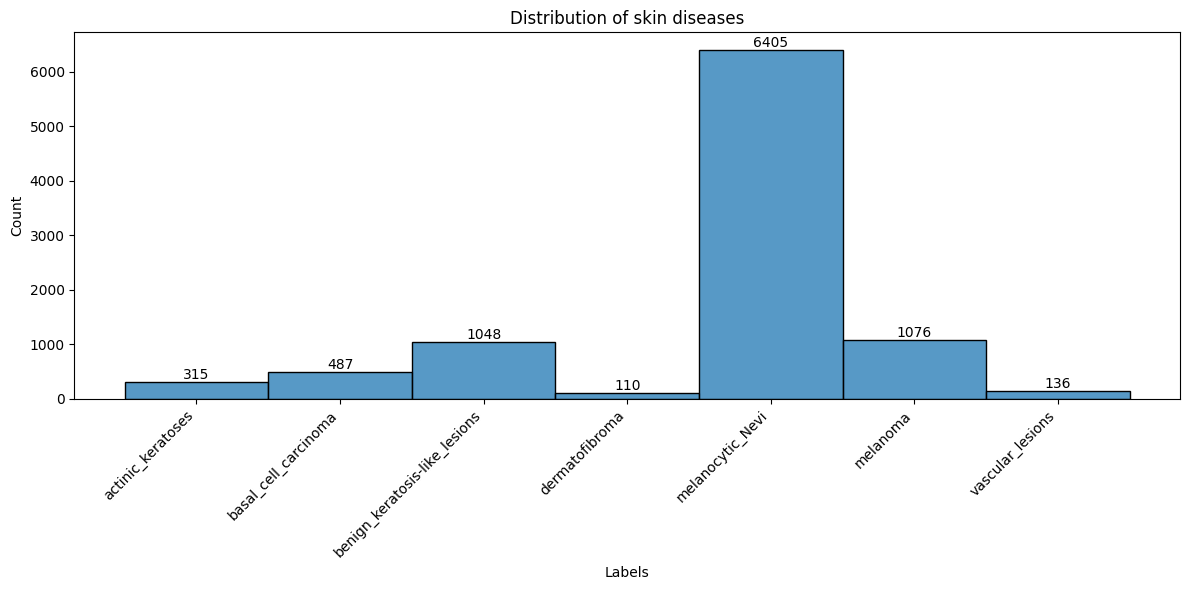

In [6]:
label_mapping = get_labels_mapping(labelencoder=le)
unique_labels = train_dataloader.dataset.tensors[1].tolist()
label_count = [label_mapping[val] for val in unique_labels]
counts = Counter(label_count)

plt.figure(figsize=(12, 6))

ax = sns.histplot(label_count, bins=len(set(label_count)), discrete=True)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.text(p.get_x() + p.get_width() / 2, height,
                f"{int(height)}", ha="center", va="bottom", fontsize=10)

ax.set_title("Distribution of skin diseases")
ax.set_xlabel("Labels")
plt.xticks(rotation=45, ha="right")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Randomly select an image and display it with its associated label.

benign_keratosis-like_lesions


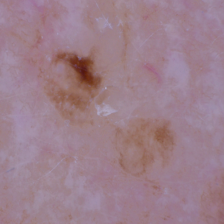

In [7]:
idx = np.random.choice(len(train_dataloader.dataset))
img = transforms.ToPILImage()(train_dataloader.dataset[idx]['image'])
label = label_mapping[train_dataloader.dataset[idx]['label'].item()]
print(label)
display(img)

# Train and evaluate model

In [8]:
model = ResNet18(num_classes=7).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
early_stopping = EarlyStopping(patience=5, delta=0)

n_epochs = 50

train_loss_history, train_accuracy_history = [], []
val_loss_history, val_accuracy_history = [], []

for epoch in range(1, n_epochs + 1):
    # Train the model
    epoch_train_loss, epoch_train_accuracy = train_model(
        model=model,
        device=device,
        train_loader=train_dataloader,
        loss_function=criterion,
        optimizer=optimizer,
        epoch=epoch,
        save=True,
        verbose=2
    )
    # Save training metrics
    train_loss_history.append(epoch_train_loss)
    train_accuracy_history.append(epoch_train_accuracy)

    # Validation part
    epoch_val_loss, epoch_val_accuracy = validate_model(
        model=model,
        device=device,
        valid_loader=valid_dataloader,
        loss_function=criterion,
        save=True,
        verbose=True
    )
    # Save validation metrics
    val_loss_history.append(epoch_val_loss)
    val_accuracy_history.append(epoch_val_accuracy)

    # Check for early stopping
    early_stopping(epoch_val_loss, model, epoch)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# If early stopping, load best model parameters in current model
early_stopping.load_best_model(model)

Train Epoch 1 [0/9577 (0%)]	Loss: 2.299444
Train Epoch 1 [640/9577 (7%)]	Loss: 1.147279
Train Epoch 1 [1280/9577 (13%)]	Loss: 1.212528
Train Epoch 1 [1920/9577 (20%)]	Loss: 0.821349
Train Epoch 1 [2560/9577 (27%)]	Loss: 0.973050
Train Epoch 1 [3200/9577 (33%)]	Loss: 0.935126
Train Epoch 1 [3840/9577 (40%)]	Loss: 1.008878
Train Epoch 1 [4480/9577 (47%)]	Loss: 0.750137
Train Epoch 1 [5120/9577 (53%)]	Loss: 0.805514
Train Epoch 1 [5760/9577 (60%)]	Loss: 0.888333
Train Epoch 1 [6400/9577 (67%)]	Loss: 0.905881
Train Epoch 1 [7040/9577 (74%)]	Loss: 0.933181
Train Epoch 1 [7680/9577 (80%)]	Loss: 0.823111
Train Epoch 1 [8320/9577 (87%)]	Loss: 0.791344
Train Epoch 1 [8960/9577 (94%)]	Loss: 0.737199

Train set : Average loss 0.8870, Accuracy : 6475/9577 (68%)

Validation set : Average Loss: 0.7996, Accuracy : 1764/2492 (71%)

Train Epoch 2 [0/9577 (0%)]	Loss: 0.653603
Train Epoch 2 [640/9577 (7%)]	Loss: 0.677481
Train Epoch 2 [1280/9577 (13%)]	Loss: 0.574829
Train Epoch 2 [1920/9577 (20%)]	Loss:

In [9]:
# Empty device cache
torch.cuda.empty_cache()

## Loss and accuracy plots

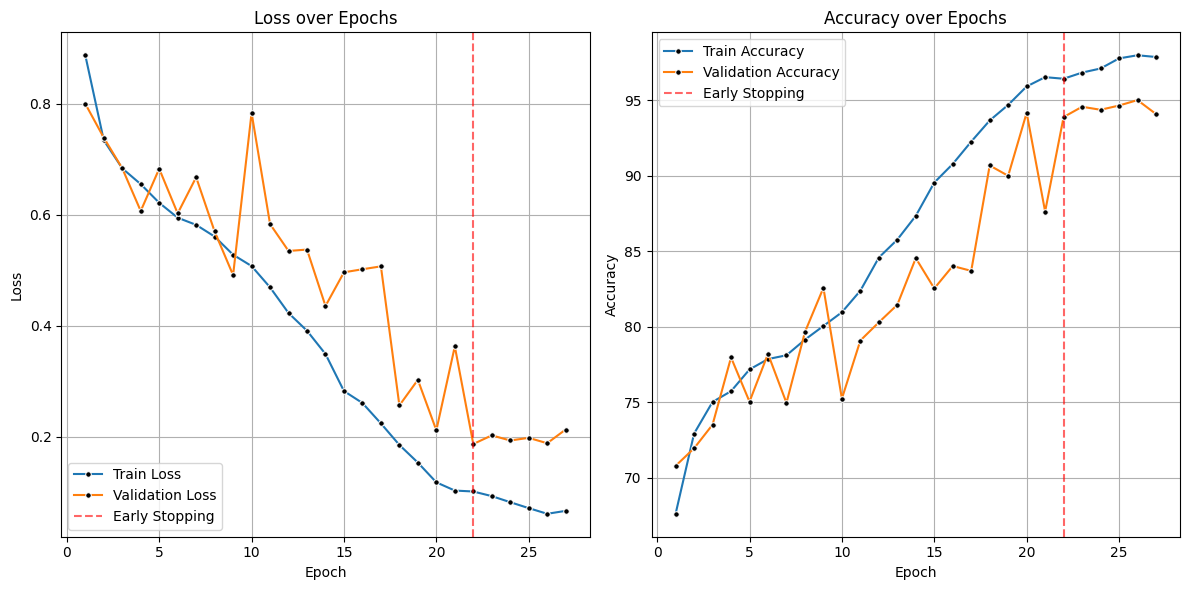

In [10]:
train_loss_history = [float(train_loss_history[i]) for i in range(len(train_loss_history))]
val_loss_history = [float(val_loss_history[i]) for i in range(len(val_loss_history))]

# If loss history were saved during training and validation then plot
if not sum(train_loss_history) == 0 and not sum(val_loss_history) == 0:

    if early_stopping.early_stop:
        early_stopping_epoch = early_stopping.epoch_stop
    else:
        early_stopping_epoch = n_epochs

    epochs = range(1, len(train_loss_history) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Loss
    sns.lineplot(x=epochs, y=train_loss_history, label='Train Loss', marker='o', markersize=4, markerfacecolor='black', ax=axes[0])
    sns.lineplot(x=epochs, y=val_loss_history, label='Validation Loss', marker='o', markersize=4, markerfacecolor='black', ax=axes[0])
    axes[0].axvline(x=early_stopping_epoch, color='red', alpha=0.6, linestyle='--', label='Early Stopping')
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Accuracy
    sns.lineplot(x=epochs, y=train_accuracy_history, label='Train Accuracy', marker='o', markersize=4, markerfacecolor='black', ax=axes[1])
    sns.lineplot(x=epochs, y=val_accuracy_history, label='Validation Accuracy', marker='o', markersize=4, markerfacecolor='black', ax=axes[1])
    axes[1].axvline(x=early_stopping_epoch, color='red', alpha=0.6, linestyle='--', label='Early Stopping')
    axes[1].set_title('Accuracy over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()
    plt.show()

# Model accuracy on test set

In [11]:
correct_per_class, total_per_class, overall_accuracy = test_model(model, device, test_dataloader, True)

Test accuracy : 1198/1285 (93.23%)


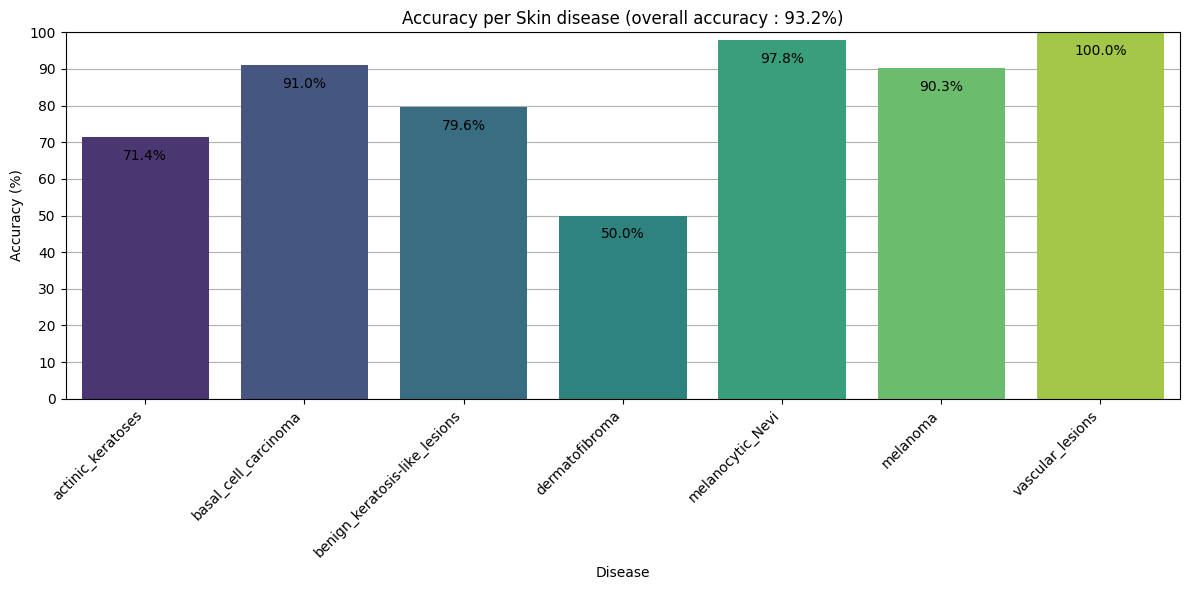

In [18]:
# Prepare data for seaborn
df = pd.DataFrame({
    "Disease": list(label_mapping.values()),
    "Accuracy (%)": [
        (correct / total) * 100 if total > 0 else 0
        for correct, total in zip(correct_per_class, total_per_class)
    ]
})

plt.figure(figsize=(12, 6))
ax = sns.barplot(x="Disease", y="Accuracy (%)", hue='Disease', data=df, palette="viridis")
ax.set_axisbelow(True)
# Annotate bars with accuracy values
for i, acc in enumerate(df["Accuracy (%)"]):
    ax.text(i, acc - 7, f"{acc:.1f}%", ha='center', va='bottom', color='black')

plt.title(f"Accuracy per Skin disease (overall accuracy : {overall_accuracy:.1f}%)")
plt.xticks(rotation=45, ha="right")
plt.yticks(range(0, 101, 10))
plt.ylim(0, 100)
plt.grid(visible=True, axis='y')
plt.tight_layout()
plt.show()

Predict on a randomly chosen image from the test set and plots the predictions with asociated probabilities

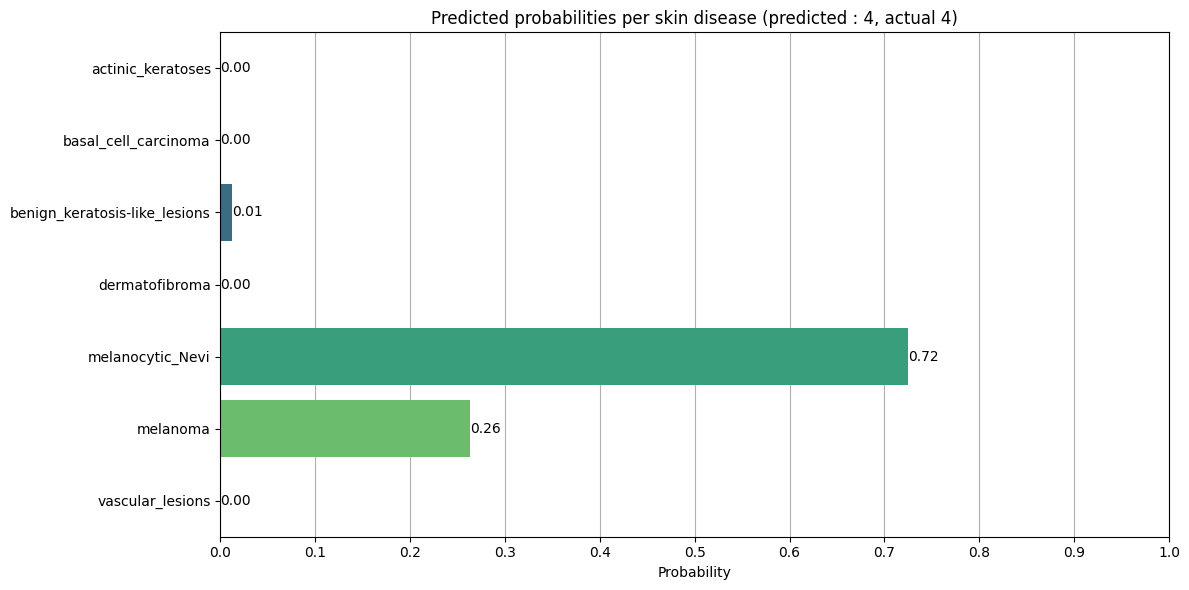

In [20]:
# Pick an example from the dataset
idx = np.random.choice(len(test_dataloader.dataset))
example = test_dataloader.dataset[idx]['image'].unsqueeze(0).to(device)
example_label = test_dataloader.dataset[idx]['label'].unsqueeze(0).to(device)

with torch.no_grad():
    output = model(example)
    predicted = output.argmax(1).item()
    actual = example_label.item()

probs = nn.functional.softmax(output[0], dim=0).tolist()

df = pd.DataFrame({
    'Class': list(label_mapping.values()),
    'Probability': probs
})

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=df, y='Class', x='Probability', hue='Class', ax=ax, palette='viridis')
ax.set_axisbelow(True)

# Add text labels
for i in range(len(df)):
    ax.text(df['Probability'][i], i, f"{df['Probability'][i]:.2f}", va='center')

ax.set_title(f"Predicted probabilities per skin disease (predicted : {predicted}, actual {actual})")
ax.set_xlabel("Probability")
ax.set_ylabel("")
plt.xticks(np.arange(0, 1.1, 0.1))
plt.xlim(0, 1)
plt.grid(visible=True, axis='x')
plt.tight_layout()
plt.show()
